In [63]:
import os
import ast
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import constants

In [64]:
def summarize(path, fname, name):
    model_meta = pd.read_csv(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['pretrain_train_losses', 'pretrain_valid_losses', 'train_losses', 'valid_losses', 'train_acc', 'valid_acc']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_losses'].apply(len)
    model_meta['final_train_loss'] = model_meta['train_losses'].apply(lambda x: x[-1])
    model_meta = model_meta.assign(approach=name)

    return model_meta

In [65]:
def read_rnn_results(root_dir, exp_dir):
    args = exp_dir.split('_')[3:]
    df = summarize(os.path.join(root_dir, exp_dir), 'trial_results.csv', 'chan_avg_rnn')

    df = df.assign(hidden_size=int(args[0].split('-')[0]))
    df = df.assign(rnn_layers=int(args[1].split('-')[0]))
    df = df.assign(fc_layers=int(args[2].split('-')[0]))
    if len(args) > 3:
        df = df.assign(bidirectional=True)
    else:
        df = df.assign(bidirectional=False)
    
    return df

In [115]:
all_model_df = pd.DataFrame()

root_dir = os.path.join(constants.RESULTS_DIR,
                        'motor_LR', 'chan_avg_rnn', 'rs',
                        'bandpass_only', 'max_abs_scale', 'lstm', 'baseline')
for d in os.listdir(root_dir):
    try:
        df = read_rnn_results(root_dir, d)
        all_model_df = all_model_df.append(df, ignore_index=True)
    except OSError:
        pass
    
train_cols = ['train_accuracy', 'train_precision', 'train_recall', 'train_f1']
test_cols = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']

In [116]:
all_model_df.columns

Index(['Status', 'final_test_loss', 'montage', 'subject', 'test_accuracy',
       'test_auc', 'test_f1', 'test_precision', 'test_recall', 'train_acc',
       'train_accuracy', 'train_auc', 'train_f1', 'train_losses',
       'train_precision', 'train_recall', 'valid_acc', 'valid_accuracy',
       'valid_auc', 'valid_f1', 'valid_loss', 'valid_losses',
       'valid_precision', 'valid_recall', 'epochs', 'final_train_loss',
       'approach', 'hidden_size', 'rnn_layers', 'fc_layers', 'bidirectional'],
      dtype='object')

## Unidirectional

In [117]:
rnn_layers = 1
fc_layers = 1
hidden_size = 32

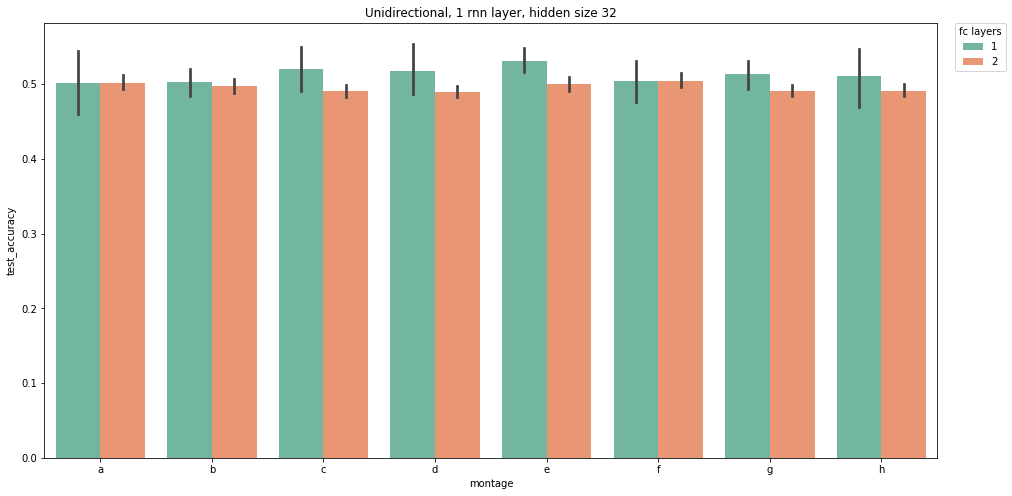

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=all_model_df[(~all_model_df['bidirectional']) & (all_model_df['rnn_layers'] == rnn_layers) & (all_model_df['hidden_size'] == hidden_size)],
            x='montage', y='test_accuracy', hue='fc_layers', palette='Set2', ax=ax, order=constants.MONTAGES)
plt.legend(title='fc layers', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'Unidirectional, {rnn_layers} rnn layer, hidden size {hidden_size}');

In [119]:
output_df = all_model_df[(~all_model_df['bidirectional']) &
                         (all_model_df['fc_layers'] == fc_layers) &
                         (all_model_df['rnn_layers'] == rnn_layers) & 
                         (all_model_df['hidden_size'] == hidden_size)].groupby('montage').mean()
output_df[test_cols + train_cols + ['epochs']].round(3)

,test_accuracy,test_precision,test_recall,test_f1,train_accuracy,train_precision,train_recall,train_f1,epochs
montage,,,,,,,,,
a,0.502,0.521,0.489,0.399,0.496,0.498,0.541,0.498,81.133
b,0.503,0.513,0.588,0.492,0.512,0.511,0.466,0.470,82.867
c,0.520,0.555,0.569,0.491,0.501,0.499,0.473,0.471,91.267
d,0.517,0.514,0.652,0.521,0.506,0.500,0.511,0.474,91.067
e,0.530,0.577,0.586,0.457,0.503,0.507,0.473,0.470,89.333
f,0.504,0.460,0.548,0.418,0.503,0.497,0.539,0.498,93.933
g,0.513,0.572,0.672,0.503,0.499,0.503,0.607,0.528,79.333
h,0.510,0.515,0.777,0.600,0.498,0.501,0.607,0.530,76.867


In [120]:
output_df = output_df[['hidden_size', 'rnn_layers', 'fc_layers',] + test_cols].round(3)
output_df.reset_index(inplace=True)
output_df.set_index = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
print(output_df.to_latex(index=False,
                         header=['Montage', 'Hidden Size', 'RNN Layers', 'FC Layers', 'Accuracy', 'Precision', 'Recall', 'F1']))

\begin{tabular}{lrrrrrrr}
\toprule
Montage & Hidden Size & RNN Layers & FC Layers & Accuracy & Precision & Recall &     F1 \\
\midrule
      a &        32.0 &        1.0 &       1.0 &    0.502 &     0.521 &  0.489 &  0.399 \\
      b &        32.0 &        1.0 &       1.0 &    0.503 &     0.513 &  0.588 &  0.492 \\
      c &        32.0 &        1.0 &       1.0 &    0.520 &     0.555 &  0.569 &  0.491 \\
      d &        32.0 &        1.0 &       1.0 &    0.517 &     0.514 &  0.652 &  0.521 \\
      e &        32.0 &        1.0 &       1.0 &    0.530 &     0.577 &  0.586 &  0.457 \\
      f &        32.0 &        1.0 &       1.0 &    0.504 &     0.460 &  0.548 &  0.418 \\
      g &        32.0 &        1.0 &       1.0 &    0.513 &     0.572 &  0.672 &  0.503 \\
      h &        32.0 &        1.0 &       1.0 &    0.510 &     0.515 &  0.777 &  0.600 \\
\bottomrule
\end{tabular}



## Train/Valid Losses

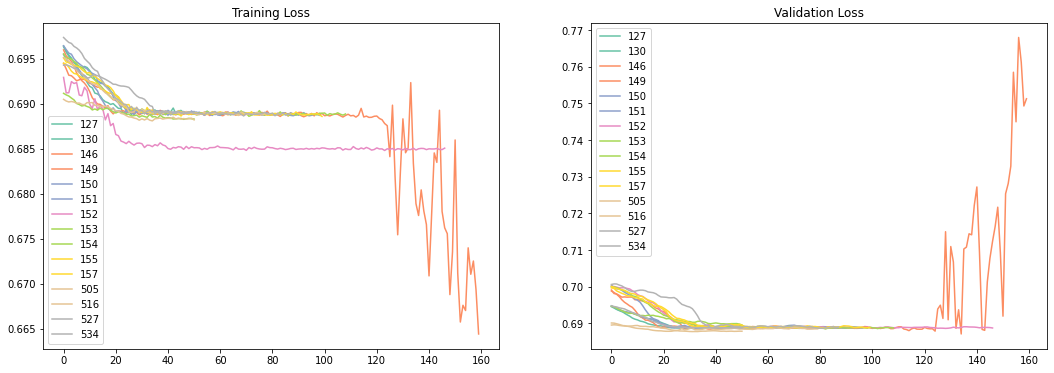

In [121]:
rnn_layers = 1
fc_layers = 1
hidden_size = 32
bidirectional = False
montage = 'e'

subset_df = all_model_df[(all_model_df['hidden_size'] == hidden_size) &
                         (all_model_df['rnn_layers'] == rnn_layers) & 
                         (all_model_df['fc_layers'] == fc_layers) & 
                         (all_model_df['bidirectional'] == bidirectional) & 
                         (all_model_df['montage'] == montage)]

n = len(subset_df)
colors = plt.cm.Set2(np.linspace(0, 1, n))

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
for i, idx in enumerate(subset_df.index):
    ax[0].plot(subset_df.loc[idx, 'train_losses'], color=colors[i])
    ax[1].plot(subset_df.loc[idx, 'valid_losses'], color=colors[i])
    ax[0].set_title('Training Loss')
    ax[1].set_title('Validation Loss')
    # ax[0].set_ylim((0, 1))
    # ax[1].set_ylim((0, 1))
    ax[0].legend(subset_df.subject.unique())
    ax[1].legend(subset_df.subject.unique())

## Train/Valid Accuracy

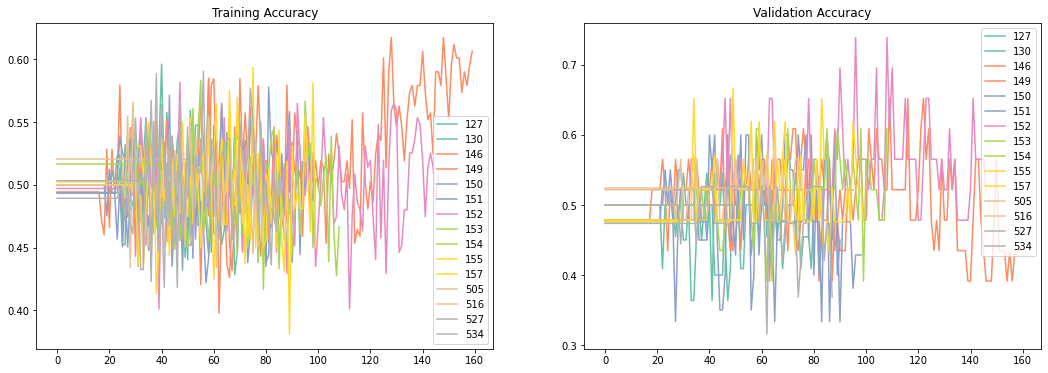

In [88]:
rnn_layers = 1
fc_layers = 1
hidden_size = 32
bidirectional = False
montage = 'e'

subset_df = all_model_df[(all_model_df['hidden_size'] == hidden_size) &
                         (all_model_df['rnn_layers'] == rnn_layers) & 
                         (all_model_df['fc_layers'] == fc_layers) & 
                         (all_model_df['bidirectional'] == bidirectional) & 
                         (all_model_df['montage'] == montage)]

n = len(subset_df)
colors = plt.cm.Set2(np.linspace(0, 1, n))

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
for i, idx in enumerate(subset_df.index):
    ax[0].plot(subset_df.loc[idx, 'train_acc'], color=colors[i])
    ax[1].plot(subset_df.loc[idx, 'valid_acc'], color=colors[i])
    ax[0].set_title('Training Accuracy')
    ax[1].set_title('Validation Accuracy')
    # ax[0].set_ylim((0, 1))
    # ax[1].set_ylim((0, 1))
    ax[0].legend(subset_df.subject.unique())
    ax[1].legend(subset_df.subject.unique())

## Bidirectional

In [89]:
rnn_layers = 1
fc_layers = 1
hidden_size = 32

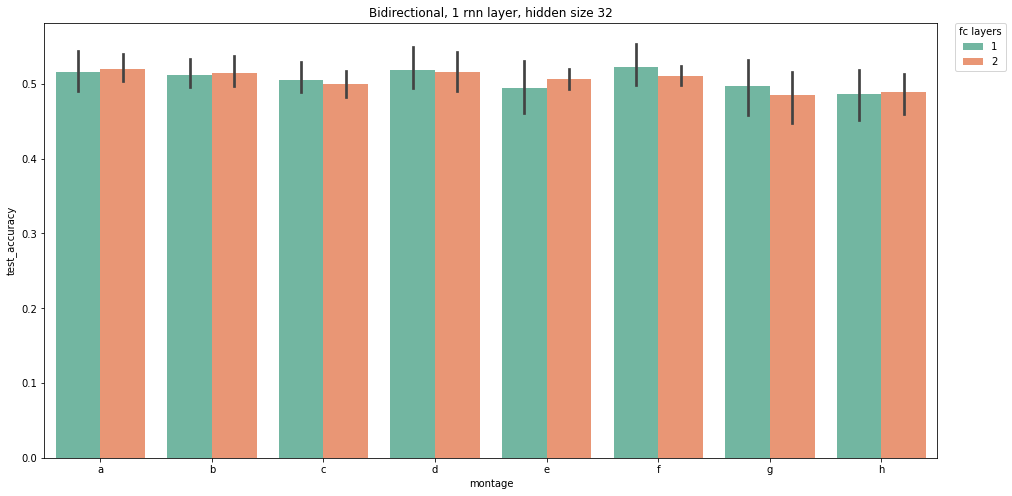

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=all_model_df[(all_model_df['bidirectional']) & (all_model_df['rnn_layers'] == rnn_layers) & (all_model_df['hidden_size'] == hidden_size)],
            x='montage', y='test_accuracy', hue='fc_layers', palette='Set2', ax=ax, order=constants.MONTAGES)
plt.legend(title='fc layers', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'Bidirectional, {rnn_layers} rnn layer, hidden size {hidden_size}');

In [91]:
output_df = all_model_df[(all_model_df['bidirectional']) &
                         (all_model_df['fc_layers'] == fc_layers) &
                         (all_model_df['rnn_layers'] == rnn_layers) & 
                         (all_model_df['hidden_size'] == hidden_size)].groupby('montage').mean()
output_df[test_cols + train_cols + ['epochs']].round(3)

,test_accuracy,test_precision,test_recall,test_f1,train_accuracy,train_precision,train_recall,train_f1,epochs
montage,,,,,,,,,
a,0.516,0.542,0.127,0.125,0.506,0.504,0.304,0.280,66.400
b,0.512,0.595,0.106,0.089,0.508,0.495,0.256,0.252,56.733
c,0.506,0.582,0.139,0.122,0.513,0.519,0.285,0.276,56.467
d,0.518,0.592,0.228,0.200,0.508,0.515,0.302,0.284,61.000
e,0.495,0.461,0.157,0.147,0.503,0.497,0.330,0.308,65.400
f,0.522,0.569,0.176,0.169,0.498,0.538,0.307,0.295,65.600
g,0.498,0.566,0.274,0.264,0.495,0.499,0.479,0.446,76.800
h,0.487,0.450,0.269,0.250,0.501,0.509,0.448,0.400,78.800


In [92]:
output_df = output_df[['hidden_size', 'rnn_layers', 'fc_layers',] + test_cols].round(3)
output_df.reset_index(inplace=True)
output_df.set_index = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
print(output_df.to_latex(index=False,
                         header=['Montage', 'Hidden Size', 'RNN Layers', 'FC Layers', 'Accuracy', 'Precision', 'Recall', 'F1']))

\begin{tabular}{lrrrrrrr}
\toprule
Montage & Hidden Size & RNN Layers & FC Layers & Accuracy & Precision & Recall &     F1 \\
\midrule
      a &        32.0 &        1.0 &       1.0 &    0.516 &     0.542 &  0.127 &  0.125 \\
      b &        32.0 &        1.0 &       1.0 &    0.512 &     0.595 &  0.106 &  0.089 \\
      c &        32.0 &        1.0 &       1.0 &    0.506 &     0.582 &  0.139 &  0.122 \\
      d &        32.0 &        1.0 &       1.0 &    0.518 &     0.592 &  0.228 &  0.200 \\
      e &        32.0 &        1.0 &       1.0 &    0.495 &     0.461 &  0.157 &  0.147 \\
      f &        32.0 &        1.0 &       1.0 &    0.522 &     0.569 &  0.176 &  0.169 \\
      g &        32.0 &        1.0 &       1.0 &    0.498 &     0.566 &  0.274 &  0.264 \\
      h &        32.0 &        1.0 &       1.0 &    0.487 &     0.450 &  0.269 &  0.250 \\
\bottomrule
\end{tabular}



## Train/Valid Losses

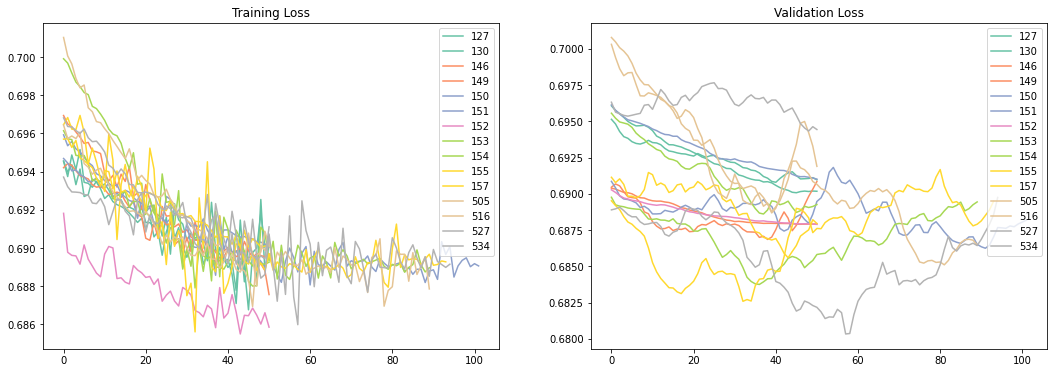

In [93]:
rnn_layers = 1
fc_layers = 1
hidden_size = 32
bidirectional = True
montage = 'e'

subset_df = all_model_df[(all_model_df['hidden_size'] == hidden_size) &
                         (all_model_df['rnn_layers'] == rnn_layers) & 
                         (all_model_df['fc_layers'] == fc_layers) & 
                         (all_model_df['bidirectional'] == bidirectional) & 
                         (all_model_df['montage'] == montage)]

n = len(subset_df)
colors = plt.cm.Set2(np.linspace(0, 1, n))

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
for i, idx in enumerate(subset_df.index):
    ax[0].plot(subset_df.loc[idx, 'train_losses'], color=colors[i])
    ax[1].plot(subset_df.loc[idx, 'valid_losses'], color=colors[i])
    ax[0].set_title('Training Loss')
    ax[1].set_title('Validation Loss')
    # ax[0].set_ylim((0, 1))
    # ax[1].set_ylim((0, 1))
    ax[0].legend(subset_df.subject.unique())
    ax[1].legend(subset_df.subject.unique())